In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal as mvn
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.gamma import Gamma
from kls import *
from torch import logsumexp
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

('probtorch:', '0.0+5a2c637', 'torch:', '1.0.0.dev20181029', 'cuda:', True)


In [2]:
N = 30
K = 3
D = 2

## Model Parameters
NUM_SAMPLES = 10
NUM_HIDDEN = 64
NUM_STATS = K+D*K+D*K
NUM_LATENTS = D * K
NUM_OBS = D
BATCH_SIZE = 100
NUM_EPOCHS = 10000
LEARNING_RATE = 1e-3
CUDA = False
PATH = 'oneshot-NG-KL'

In [3]:
Xs = torch.from_numpy(np.load('gmm_dataset/sequences.npy')).float()
Zs_true = torch.from_numpy(np.load('gmm_dataset/states.npy')).float()
# mus_true = torch.from_numpy(np.load('gmm_dataset/means.npy')).float()
# covs = torch.from_numpy(np.load('gmm_dataset2/covariances.npy')).float()
Pi = torch.from_numpy(np.load('gmm_dataset/init.npy')).float()
num_seqs = Xs.shape[0]

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_stats=NUM_STATS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_stats = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_stats))
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.ReLU())
        self.sigmas_log_alpha = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        self.sigmas_log_beta = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
        self.enc_hidden2 = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.ReLU())
        self.mus_mean = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        self.mus_log_nu = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, K, D, num_samples, batch_size):
        stats = self.enc_stats(obs).view(batch_size, N, -1).sum(1)
        hidden = self.enc_hidden(stats)
        q_alpha = torch.exp(self.sigmas_log_alpha(hidden)).view(-1, K, D) ## B * K * D
        q_beta = torch.exp(self.sigmas_log_beta(hidden)).view(-1, K, D) ## B * K * D
        precisions = Gamma(q_alpha, q_beta).sample((num_samples,)) ## S * B * K * D
        
        hidden2 = self.enc_hidden2(stats)          
        q_mean = self.mus_mean(hidden2).view(-1, K, D).unsqueeze(0).repeat(num_samples, 1, 1, 1)
        q_nu = torch.exp(self.mus_log_nu(hidden2).view(-1, K, D))
        q_sigma = torch.sqrt(1. / (q_nu.unsqueeze(0).repeat(num_samples, 1, 1, 1) * precisions))
        mus = Normal(q_mean, q_sigma).sample()  
        return q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 1e-2)  
        
def initialize():
    enc = Encoder()
    enc.apply(weights_init)
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    
    return enc, optimizer
enc, optimizer = initialize()

In [6]:
prior_mean = torch.zeros((BATCH_SIZE, K, D))
prior_nu = torch.ones((BATCH_SIZE, K, D))
prior_alpha = torch.ones((BATCH_SIZE, K, D)) * 2.0
prior_beta = torch.ones((BATCH_SIZE, K, D)) * 2.0

def log_joints_gmm(X, mus, precisions, N, D, K, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size):
    log_probs = torch.zeros(batch_size).float()
    ## B
    log_probs = log_probs + Gamma(prior_alpha, prior_beta).log_prob(precisions).sum(-1).sum(-1)
    prior_sigma = 1. / torch.sqrt(prior_nu * precisions)
    sigmas = 1. / torch.sqrt(precisions)
    log_probs = log_probs + Normal(prior_mean, prior_sigma).log_prob(mus).sum(-1).sum(-1)
    sigmas_expand = sigmas.unsqueeze(0).repeat(N, 1, 1, 1).transpose(0, 2) ## K * B * N * D
    mus_expand = mus.unsqueeze(0).repeat(N, 1, 1, 1).transpose(0, 2) ## K * B * N * D
    log_p_lls = Normal(mus_expand, sigmas_expand).log_prob(X).sum(-1) ## K * B * N
    log_probs = log_probs + logsumexp(log_p_lls, dim=0).sum(-1) - N * torch.log(torch.FloatTensor([K]))
    return log_probs

def post_global(x, z, prior_mean, prior_nu, prior_alpha, prior_beta, N, K, D, batch_size):
    stat1 = z.sum(1).unsqueeze(-1).repeat(1, 1, D) ## B * K * D
    xz_nk = torch.mul(z.unsqueeze(-1).repeat(1, 1, 1, D), x.unsqueeze(-1).repeat(1, 1, 1, K).transpose(-1, -2)) # B*N*K*D
    stat2 = xz_nk.sum(1) ## B*K*D
    stat3 = torch.mul(z.unsqueeze(-1).repeat(1, 1, 1, D), torch.mul(x, x).unsqueeze(-1).repeat(1, 1, 1, K).transpose(-1, -2)).sum(1) 
    stat1_nonzero = stat1
    stat1_nonzero[stat1_nonzero == 0.0] = 1.0
    x_bar = stat2 / stat1
    posterior_beta = prior_beta + (stat3 - (stat2 ** 2) / stat1_nonzero) / 2. + (stat1 * prior_nu / (stat1 + prior_nu)) * ((prior_nu**2) + x_bar**2 - 2 * x_bar *  prior_nu) / 2.
    posterior_nu = prior_nu + stat1
    posterior_mean = (prior_mean * prior_nu + stat2) / (prior_nu + stat1) 
    posterior_alpha = prior_alpha + (stat1 / 2.)
#     posterior_sigma = torch.sqrt(posterior_nu * (posterior_beta / posterior_alpha))
    return posterior_mean, posterior_nu, posterior_alpha, posterior_beta

def oneshot(x, z, Pi, N, K, D, num_samples, batch_size):
    posterior_mean, posterior_nu, posterior_alpha, posterior_beta = post_global(x, z, prior_mean, prior_nu, prior_alpha, prior_beta, N, K, D, batch_size)
    log_ps = torch.zeros((num_samples, batch_size))
    log_qs = torch.zeros((num_samples, batch_size))
    kls_ex = torch.zeros((num_samples, batch_size))
    kls_in = torch.zeros((num_samples, batch_size))
    data = x.view(batch_size*N, -1)
    q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions = enc(data, K, D, num_samples, batch_size)  
    for l in range(num_samples):
        log_qs[l] =  Normal(q_mean[l], q_sigma[l]).log_prob(mus[l]).sum(-1).sum(-1) + Gamma(q_alpha, q_beta).log_prob(precisions[l]).sum(-1).sum(-1)## B
        log_ps[l] = log_joints_gmm(x, mus[l], precisions[l], N, D, K, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size)
        kl_ex, kl_in = kls_NGs(posterior_mean, posterior_nu, posterior_alpha, posterior_beta, q_mean[l], q_nu, q_alpha, q_beta)
        kls_ex[l] = kl_ex
        kls_in[l] = kl_in
    log_weights = log_ps - log_qs
    weights = torch.exp(log_weights - logsumexp(log_weights, dim=0)).detach()
    eubo = torch.mul(weights, log_weights).sum(0).mean()
    elbo = log_weights.mean(0).mean()
    ess = (1. / (weights ** 2).sum(0)).mean()
    return eubo, elbo, ess, kls_ex.mean(0).mean(), kls_in.mean(0).mean()

def shuffler(batch_Xs, batch_Zs, N, K, D, batch_size):
    indices = torch.cat([torch.randperm(N).unsqueeze(0) for b in range(batch_size)])
    indices_Xs = indices.unsqueeze(-1).repeat(1, 1, D)
    indices_Zs = indices.unsqueeze(-1).repeat(1, 1, K)
    return torch.gather(batch_Xs, 1, indices_Xs), torch.gather(batch_Zs, 1, indices_Zs)

In [7]:
EUBOs = []
ELBOs = []
ESSs = []
KLs_in = []
KLs_ex = []

num_batches = int((Xs.shape[0] / BATCH_SIZE))
time_start = time.time()
for epoch in range(NUM_EPOCHS):
    indices = torch.randperm(num_seqs)

    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    KL_ex = 0.0
    KL_in = 0.0
    for step in range(num_batches):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        batch_Xs = Xs[batch_indices]
        batch_Zs = Zs_true[batch_indices]
        batch_Xs, batch_Zs = shuffler(batch_Xs, batch_Zs, N, K, D, BATCH_SIZE)
        eubo, elbo, ess, kl_ex, kl_in = oneshot(batch_Xs, batch_Zs, Pi, N, K, D, NUM_SAMPLES, BATCH_SIZE)
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
        KL_ex += kl_ex.item()
        KL_in += kl_in.item()

    EUBO /= num_batches
    ELBO /= num_batches
    ESS /= num_batches
    KL_ex /= num_batches
    KL_in /= num_batches
    
    EUBOs.append(EUBO)
    ELBOs.append(ELBO)
    ESSs.append(ESS)
    KLs_ex.append(KL_ex)
    KLs_in.append(KL_in)
    
    if epoch % 10 == 0:
        time_end = time.time()
        print('epoch=%d, EUBO=%f, ELBO=%f, ESS=%.3f, EX=%.3f, IN=%.3f (%ds)' % (epoch, EUBO, ELBO, ESS, KL_ex, KL_in, time_end - time_start))
        time_start = time.time()

epoch=0, EUBO=-202.522995, ELBO=-327.752155, ESS=1.068, EX=477.408, IN=27.531 (0s)
epoch=10, EUBO=-175.738045, ELBO=-206.848621, ESS=1.173, EX=135.592, IN=65.864 (2s)
epoch=20, EUBO=-174.405852, ELBO=-205.245702, ESS=1.180, EX=135.131, IN=57.527 (2s)
epoch=30, EUBO=-174.383755, ELBO=-204.642070, ESS=1.181, EX=134.099, IN=54.703 (2s)
epoch=40, EUBO=-173.601750, ELBO=-204.260330, ESS=1.193, EX=133.053, IN=56.612 (2s)
epoch=50, EUBO=-170.583803, ELBO=-197.005885, ESS=1.221, EX=131.098, IN=66.295 (2s)
epoch=60, EUBO=-169.887210, ELBO=-196.757378, ESS=1.235, EX=140.905, IN=66.868 (2s)
epoch=70, EUBO=-169.309357, ELBO=-197.671169, ESS=1.223, EX=157.137, IN=68.430 (2s)
epoch=80, EUBO=-168.512439, ELBO=-193.667082, ESS=1.205, EX=169.774, IN=92.301 (2s)
epoch=90, EUBO=-167.385278, ELBO=-189.649033, ESS=1.242, EX=177.000, IN=90.369 (2s)
epoch=100, EUBO=-165.405049, ELBO=-183.966734, ESS=1.322, EX=144.248, IN=90.177 (2s)
epoch=110, EUBO=-164.546063, ELBO=-183.864462, ESS=1.296, EX=156.691, IN=77.

KeyboardInterrupt: 

In [40]:
torch.save(enc.state_dict(), 'models/enc-' + PATH)

In [41]:
def save_results(EUBOs, ELBOs, ESSs, KLs_ex, KLs_in):
    fout = open('results/logs-' + PATH +'.txt', 'w+')
    fout.write('EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in\n')
    for i in range(len(EUBOs)):
        fout.write(str(EUBOs[i]) + ', ' + str(ELBOs[i]) + ', ' + str(ESSs[i]) 
                   + str(KLs_ex[i]) + str(KLs_in[i]) + '\n')
    fout.close()
save_results(EUBOs, ELBOs, ESSs, KLs_ex, KLs_in)

In [42]:
def plot_results(EUBOs, ELBOs, ESSs, KLs_ex, KLs_in, num_samples, num_epochs, lr):
    fig = plt.figure(figsize=(20, 30))
    fig.tight_layout()
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3)
    ax1.plot(EUBOs, 'r', label='EUBOs')
    ax1.plot(ELBOs, 'b', label='ELBOs')
    ax2.plot(KLs_ex, '#66b3ff', label='exclusive KL')
    ax2.plot(KLs_in, '#99ff99', label='inclusive KL')
    
    ax1.tick_params(labelsize=18)
    ax3.plot(np.array(ESSs) / num_samples, 'm', label='ESS')
    ax1.set_title('epoch=%d, batch_size=%d, lr=%.1E, samples=%d' % (num_epochs, BATCH_SIZE, lr, num_samples), fontsize=18)
    ax1.set_ylim([-220, -130])
    ax1.legend()
    ax2.set_ylim([-50, 50])
    ax2.legend()
    ax3.legend()
    ax2.tick_params(labelsize=18)
    ax3.tick_params(labelsize=18)
    plt.savefig('results/train-' + PATH + '.svg')

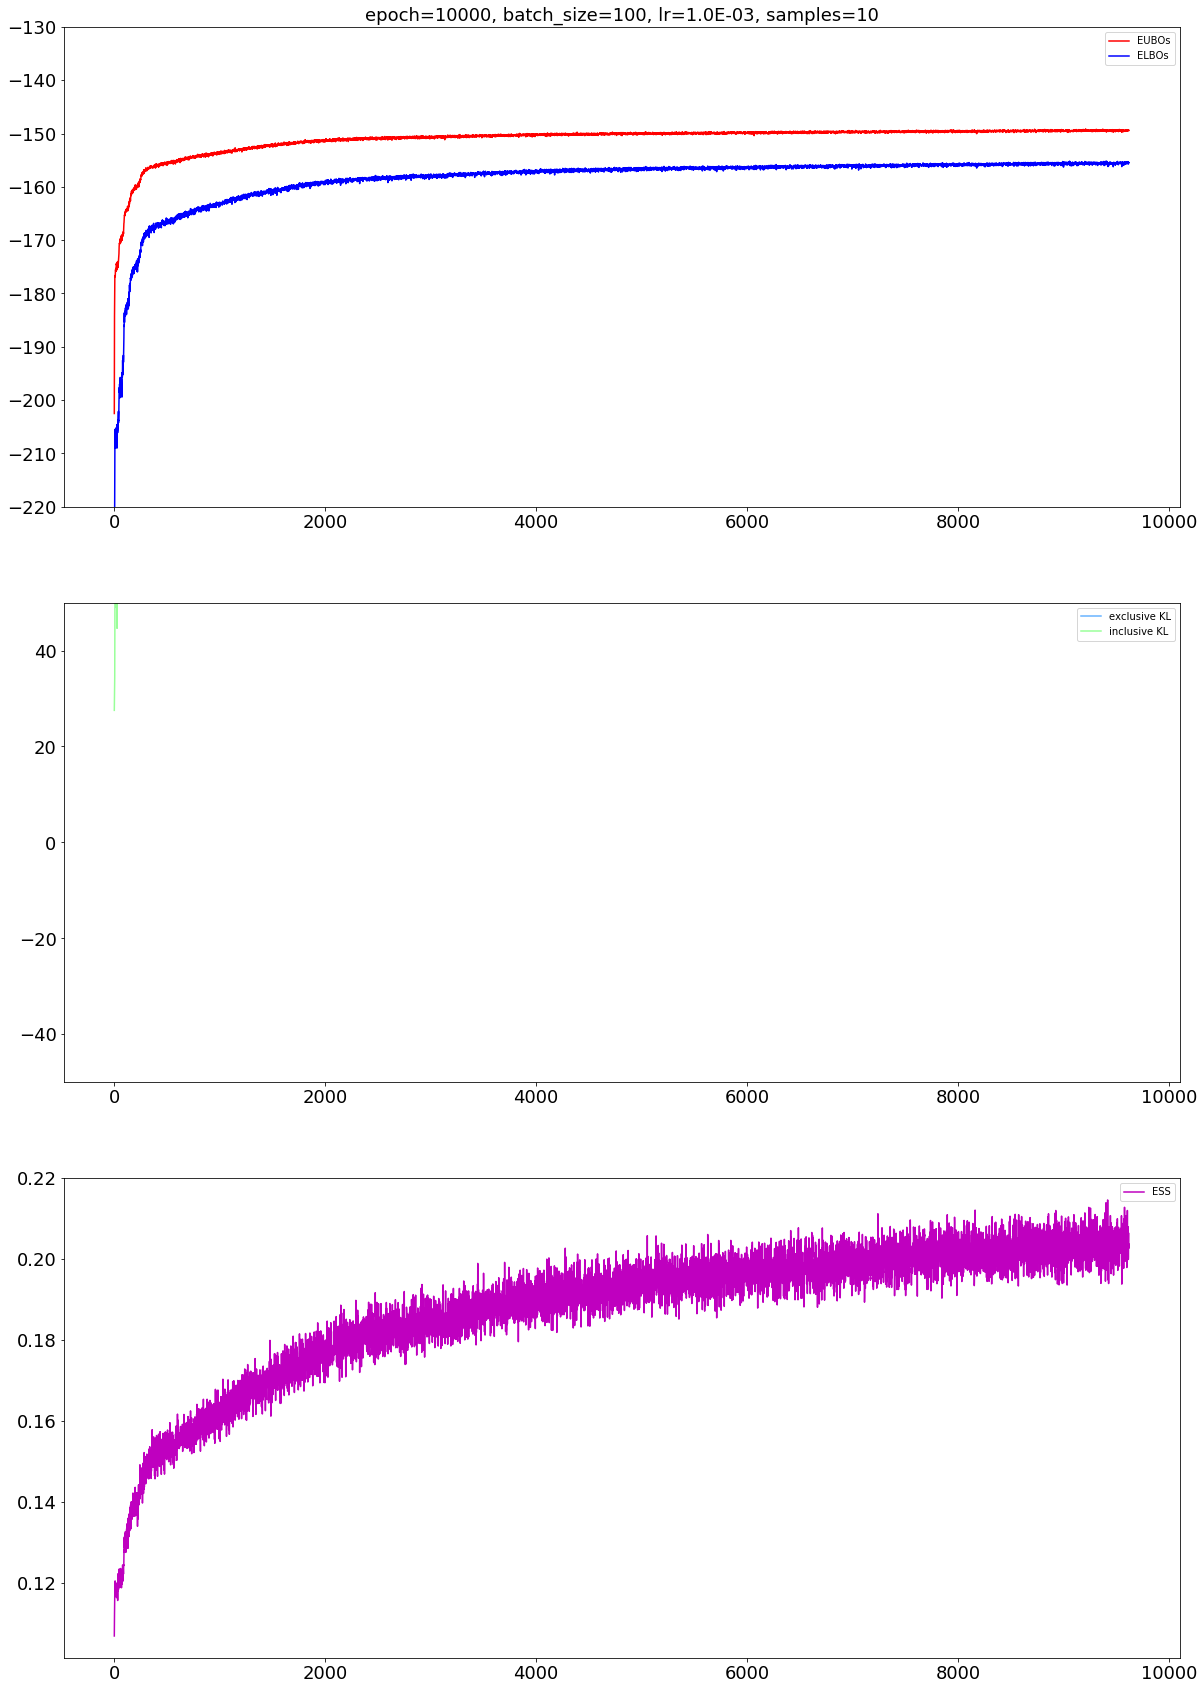

In [43]:
plot_results(EUBOs, ELBOs, ESSs, KLs_ex, KLs_in, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE)

In [44]:
def sample_single_batch(num_seqs, N, K, D, batch_size):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    batch_Xs = Xs[batch_indices]
    batch_Zs = Zs_true[batch_indices]
    batch_Xs, batch_Zs = shuffler(batch_Xs, batch_Zs, N, K, D, batch_size)
    return batch_Xs, batch_Zs

def test(x, z, num_seqs, Pi, N, K, D, batch_size):
    LLs = [] 
    data = x.view(batch_size*N, -1)
    q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions = enc(data, K, D, 1, batch_size)  
    labels = z.nonzero()
    sigmas = 1. / torch.sqrt(precisions[0])
    
    ll = Normal(mus[0][labels[:, 0], labels[:, -1], :].view(batch_size, N, D), sigmas[labels[:, 0], labels[:, -1], :].view(batch_size, N, D)).log_prob(x).sum(-1).sum(-1).mean()
    LLs.append(ll.item())
    E_precisions = q_alpha / q_beta
    E_mus = q_mean[0]

    return mus, precisions, LLs, E_mus, E_precisions
x,z_true = sample_single_batch(num_seqs, N, K, D, BATCH_SIZE)
mus, precisions, LLs, E_mus, E_precisions = test(x, z_true, num_seqs, Pi, N, K, D, BATCH_SIZE)

In [45]:
def plot_final_samples(Xs, Zs, mus, precisions, batch_size):
    colors = ['r', 'b', 'gold']
    fig = plt.figure(figsize=(25,100))
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = Xs[b].data.numpy()
        z = Zs[b]
        mu = mus[b].data.numpy()
        precision = precisions[b].data.numpy()

        covs = np.zeros((K, D, D))
        assignments = (z.nonzero()[:, -1]).data.numpy()
        for k in range(K):
            covs[k] = np.diag(1. / precision[k])
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
            plot_cov_ellipse(cov=covs[k], pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
        ax.set_ylim([-10, 10])
        ax.set_xlim([-10, 10])
#     plt.savefig('results/modes' + PATH + '.svg')

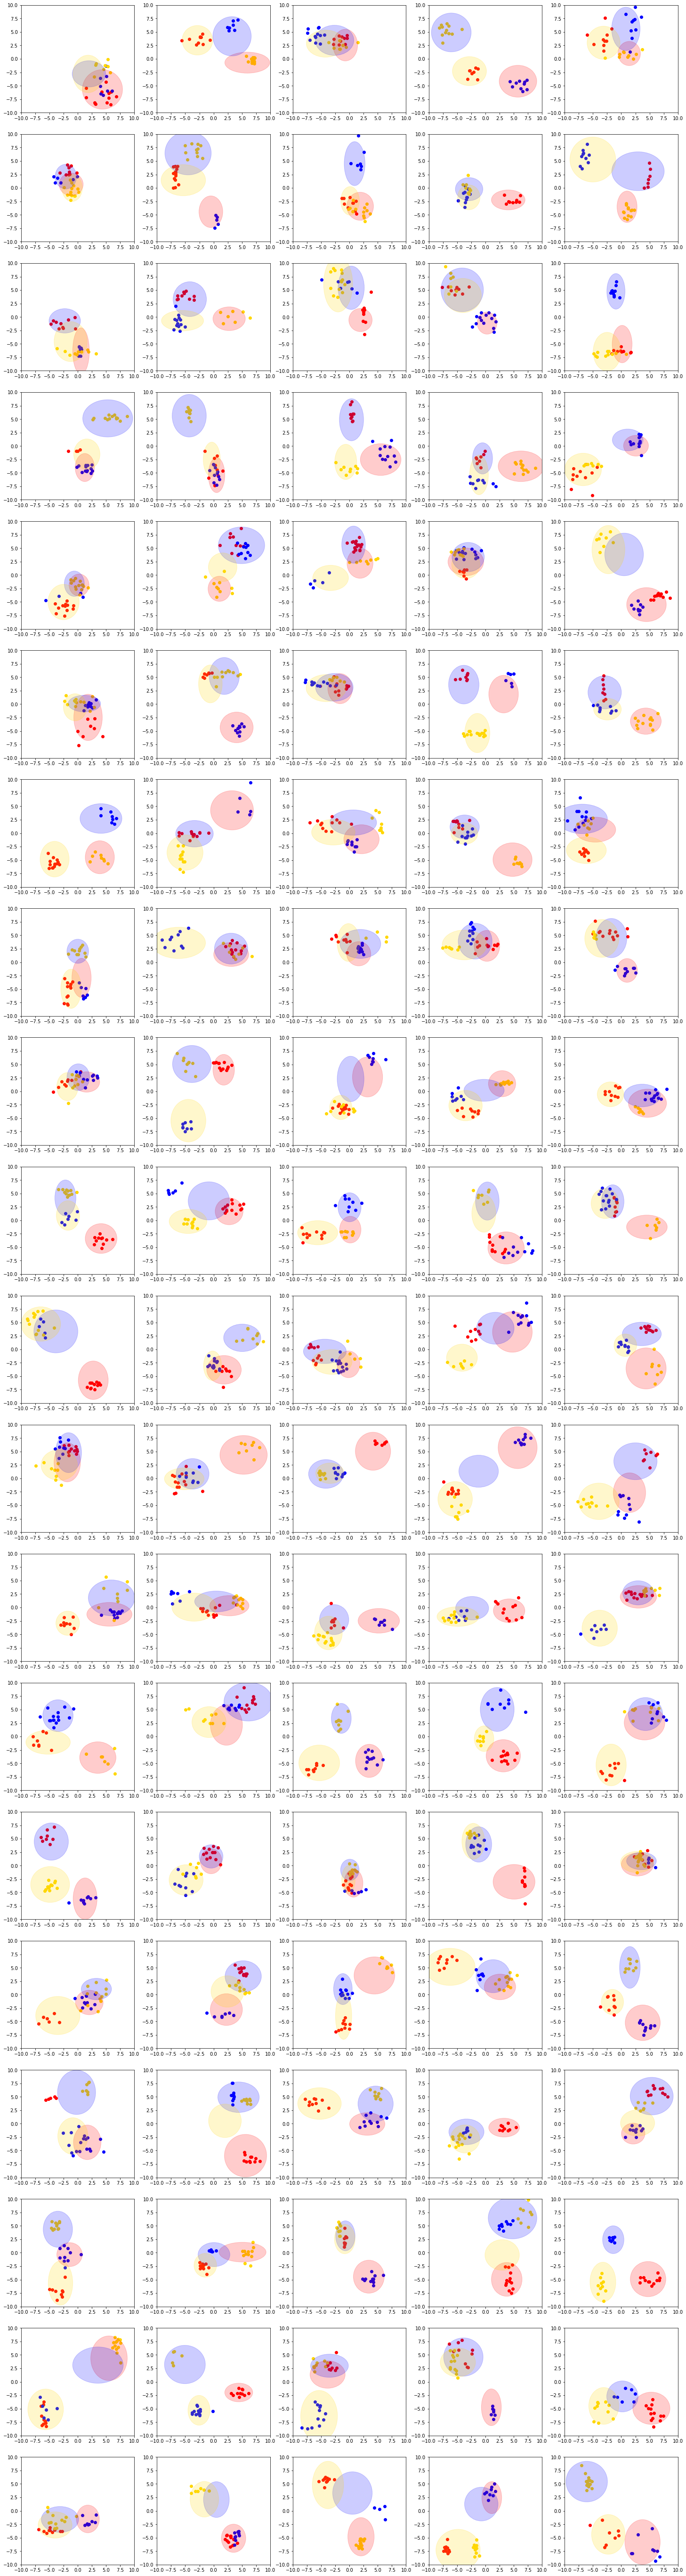

In [46]:
plot_final_samples(x, z_true, E_mus, E_precisions, BATCH_SIZE)